In [38]:
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt

k_factor = 1
voxelr = 0.005  
L = 350*voxelr
print 'L',L
D = 1
kd= 4.0*math.pi*D*2*voxelr
ka = k_factor*kd
kon = (ka*kd)/(ka+kd)
tm =(2*voxelr)**2/(6*D)
N = 4000
duration = -math.log(1e-10)/N/kon
dt=tm*10
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,voxelr)
lx,ly,lz = tuple(w.calculate_shape(ones()*L,voxelr))
Nv = lx*ly*lz
vv = w.calculate_voxel_volume(voxelr)
phi = 2.*N/Nv
print 'Vr',Vr
print ka,kd,kon
print 'phi',phi*100,'phir',2*N*100*vv/Vr
print kon
Pacc = ka / (6 * math.sqrt(2) * D * voxelr)
print Pacc

L 1.75
Vr 5.48379976429
0.125663706144 0.125663706144 0.0628318530718
phi 0.103155740411 phir 0.103155740411
0.0628318530718
2.96192195877


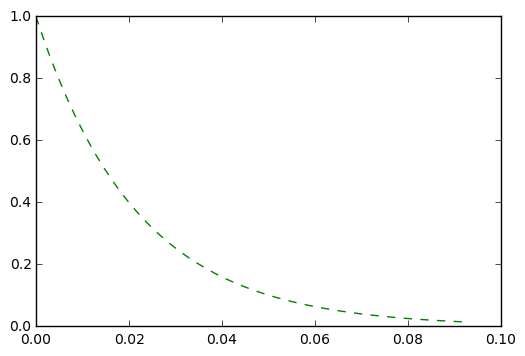

In [2]:
with reaction_rules():#for ODE
    A +B > B | kon

m1 = get_model()

ode = np.array(run_simulation(duration, model=m1, y0={'A': N,'B': N}, solver='ode', volume=Vr, return_type='array'))
to = ode[:,0]
nao = ode[:,1]
plt.plot(to,nao/N,'g--')

In [3]:
with species_attributes():
    A |  {'D': str(0), 'radius':str(voxelr)}
    B |  {'D': str(D), 'radius':str(voxelr)}

with reaction_rules():#for spa and egfrd
    A + B > B | ka

m2 = get_model()

def singlerun(i):
    rng = GSLRandomNumberGenerator()
    rng.seed(i)
    #w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxelr, Integer3(3, 3, 3), rng)
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr,rng)
    w.bind_to(m2)
    #ll= tuple(w.actual_lengths())
    #print ll[0]*ll[1]*ll[2]
    w.add_molecules(Species('A'), N)
    w.add_molecules(Species('B'), N)
    obs = FixedIntervalNumberObserver(dt, ('A'))
    sim = spatiocyte.SpatiocyteSimulator(w)
    sim.initialize()
    #print sim.dt(),tm/Pa
    sim.run(duration, obs)    
    return np.array(obs.data())


In [4]:
def runspa(run):   
    leng = int((duration/dt)+1)
    n = np.empty([run,leng])
    for i in range(run):
        spa = singlerun(i)
        n[i] = spa[:,1]        
    ts = spa[:,0]
    return ts,n


In [5]:
run = 10000
#te,nae = rungtest(run)
#print len(te)
ts,nas = runspa(run)


In [6]:
mean = np.mean(nas,axis=0)
std = np.std(nas,axis=0)

[ 55.7923  55.3562  54.9295  54.4976  54.0712  53.6539  53.236   52.827
  52.4209  52.0041]


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


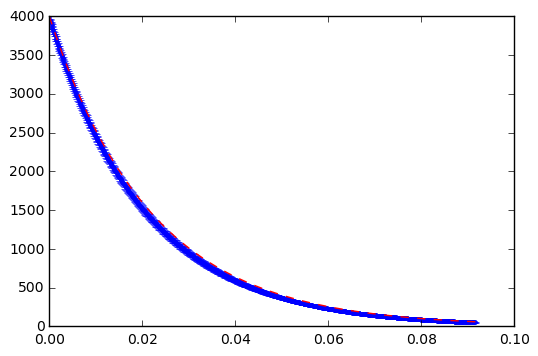

In [7]:
plt.errorbar(ts,mean,std,fmt=' ',marker='.')
plt.plot(to,nao,'r--')
print mean[-10:]

dt 0.000333333333333 1.66666666667e-05
2.96192195877
0.125663706144 0.0628318530718 0.0621833349826
0.063968992878


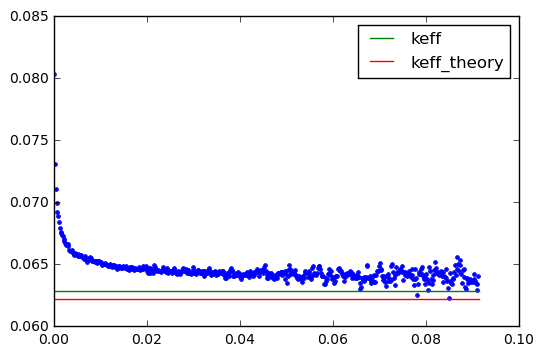

In [8]:
l=2
print 'dt',ts[l]-ts[0],tm
ks = -Vr *(mean[l:]-mean[:-l])/mean[:-l]/(ts[l]-ts[0])/N
plt.plot(ts[int(l*0.5):-int(l*0.5)],ks,'.')
Pacc = ka / (6 * math.sqrt(2) * D * voxelr)
print Pacc
r0=0.256318
kefftheory = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)*Pacc/(Pacc+1/r0 -1)
plt.plot(ts,[kon]*len(ts),label='keff')
plt.plot(ts,[kefftheory]*len(ts),label='keff_theory')
plt.legend()
print ka,kon,kefftheory
km = np.mean(ks[-50:])
print km

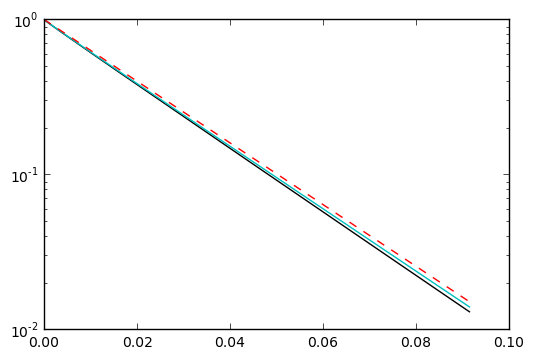

In [9]:
#C =1.02085
#r0=0.256318
#voxelr = 0.005/C
#kd = 4*np.pi*4*D*voxelr
#kaa = k_factor*4.0*math.pi*D*4*0.005
#ka = kaa*kd/(3*2**0.5 *D*4*0.005*(1/r0 -1))
#kon = (ka*kd)/(ka+kd)

#import scipy.integrate as integrate
def Phi(xx):
    return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

tau = ((ka*2*voxelr/(ka+kd))**2)/(D)
#tt= np.linspace(0,0.5,1e3)
#def kt(t):
#    x=ka*((t/tau)**(0.5))/kd
#    return kon*(1+(ka*phi(x)/kd))
#intkt = [integrate.quad(lambda t: kt(t),0,T)[0] for T in tt] 

tt=ts
intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in tt]

st = [math.exp(-ik*N/Vr) for ik in intkt]
#plt.errorbar(ts,mean/N,std/N,fmt=' ',marker='.')
plt.plot(ts,mean/N,'k')
plt.plot(tt,st,'c-')
plt.semilogy(to,nao/N,'r--')
#plt.ylim(0.4,1)

[ 39.5847  39.5558  39.5246  39.4922  39.4621]
ka,kon,kefftheory
0.125663706144 0.0628318530718 0.0621833349826


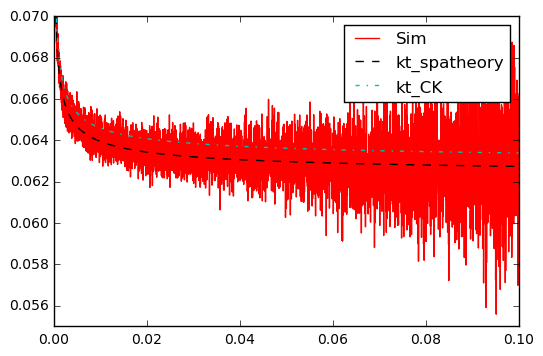

In [72]:
#original, trials=1k, alpha=0.1
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt
dat = np.loadtxt('kfac1a01meanNa',delimiter=',')

tc=dat[:,0]
mnac=dat[:,1]
print mnac[-5:]

k_factor = 1
voxelr = 0.005  
L = 350*voxelr
D = 1
kd= 4.0*math.pi*D*2*voxelr
ka = k_factor*kd
kon = (ka*kd)/(ka+kd)
tm =(2*voxelr)**2/(6*D)
N = 4000
duration = -math.log(1e-10)/N/kon
dt=tm*10
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,voxelr)

def getkt2(st,t): #two-point
    ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(t[2]-t[0])/N
    return ks

def getkt5(st,t): #five-point
    s1=st[0:-5]
    s2=st[1:-4]
    s4=st[3:-2]
    s5=st[4:-1]
    ks2= (-Vr*(-s5+8*s4-8*s2+s1)/s1/N/12./t[1]-t[0])
    return ks2

ks = getkt2(mnac,tc)
plt.plot(tc[1:-1],ks,'r-',label='Sim')

#plt.plot(tc[2:-3],ks2,'c-',label='five-point D')
r0=0.256318
Pacc= ka/3/2**0.5/D/2/voxelr
kdd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
kefftheory = kdd*Pacc/(Pacc+1/r0 -1)
#plt.plot(tc,[kon]*len(tc),label='keff')
#plt.plot(tc,[kefftheory]*len(tc),label='keff_theory')
print 'ka,kon,kefftheory'
print ka,kon,kefftheory
#lp = 200
#kstd=np.std(ks[-lp:])
#km = np.mean(ks[-lp:])
#print km,km-kstd,km+kstd
#print kstd
#print (km-kefftheory)*100/kefftheory
#print tc[-lp]

def Phi(xx):
    return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

def getktt(ka,kdd,rm,tc):
    tau = ((ka*2*rm/(ka+kdd))**2)/(D)
    kt1 = [(ka*kdd/(ka+kdd))*(1+(ka/kdd)*Phi(ka*(t/tau)**0.5 /kdd)) for t in tc]
    return kt1

kt1 = getktt(ka,kdd,voxelr,tc)
kt2 = getktt(ka,kd,voxelr,tc)
plt.plot(tc,kt1,'k--',label='kt_spatheory')
plt.plot(tc,kt2,'c-.',label='kt_CK')
#plt.xlim([0.09,0.1])
plt.ylim([0.055,0.07])
plt.legend()


In [73]:
ll=-3000
z=-2000
ksm = np.mean(ks[1:-1][ll:z])
kt1m = np.mean(kt1[1:-1][ll:z])
kt2m = np.mean(kt2[1:-1][ll:z])
print (ksm-kt1m)*100/kt1m,(ksm-kt2m)*100/kt2m

-0.0785682455589 -1.0980870451


0.0491666666667
[ 39.69101562  39.66621094  39.63476562  39.60390625  39.57265625
  39.54453125  39.51660156  39.48574219  39.45234375  39.4203125 ]


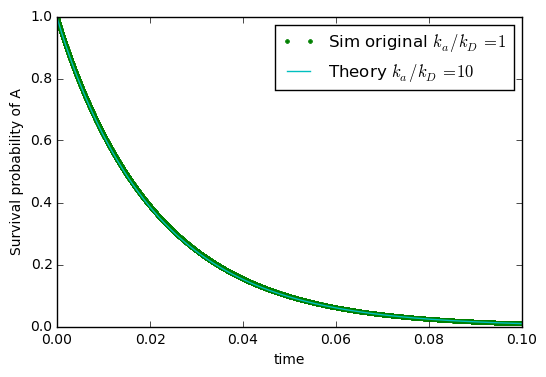

In [10]:
rm=voxelr
tau = ((ka*2*rm/(ka+kd))**2)/(D)
T=np.arange(0,0.1,tm*10)
intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in T]

st = np.array([math.exp(-ik*N/Vr) for ik in intkt])
print T[st<0.1][0]
#plt.plot(tt[::40],(mna/N)[::40],'r.',label='Sim original $k_a/k_D=0.1$')
plt.plot(tc[::1],(mnac/N)[::1],'g.',label='Sim original $k_a/k_D=1$')
plt.plot(T,st,'c-',label='Theory $k_a/k_D=10$')
plt.legend(loc='best')
plt.ylabel('Survival probability of A')
plt.xlabel('time')
print mnac[-10:]
#plt.savefig("figure/survival_probability_ori_correct_theory.png",format='png',dpi=300)    

0.0630825526763
0.0628318530718


(0.062, 0.066)

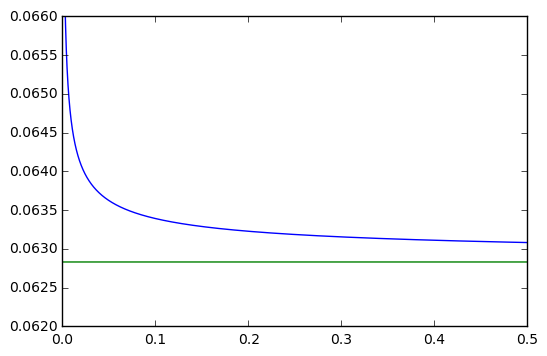

In [122]:
#T=np.arange(0,1,tm*100)
kt = np.array([kon*(1+(ka/kd)*Phi(ka*(t/tau)**0.5 /kd)) for t in T])
ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(T[2]-T[0])/N
#print ks[-1]
print kt[-1]
print kon
#plt.plot(T[1:-1],ks,'r.',label='two-point D')
plt.plot(T,kt)
plt.plot(T,[kon]*len(T),label='keff')
plt.ylim(0.062,0.066)

[ 396.46894  395.2587   394.05518  392.84736  391.65022]
ka,kon,kefftheory
0.125663706144 0.0628318530718 0.0621833349826


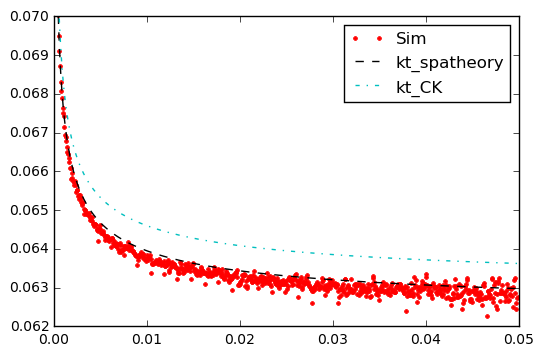

In [130]:
#original, trials=5e4, alpha=0.1
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt
dat = np.loadtxt('kfac1.0a01meanNa',delimiter=',')
lg=4
tc=dat[:,0][::lg]
mnac=dat[:,1][::lg]
print mnac[-5:]

k_factor = 1
voxelr = 0.005  
L = 350*voxelr
D = 1
kd= 4.0*math.pi*D*2*voxelr
ka = k_factor*kd
kon = (ka*kd)/(ka+kd)
tm =(2*voxelr)**2/(6*D)
N = 4000
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,voxelr)

def getkt2(st,t): #two-point
    ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(t[2]-t[0])/N
    return ks

def getkt5(st,t): #five-point
    s1=st[0:-5]
    s2=st[1:-4]
    s4=st[3:-2]
    s5=st[4:-1]
    ks2= (-Vr*(-s5+8*s4-8*s2+s1)/s1/N/12./t[1]-t[0])
    return ks2

ks = getkt2(mnac,tc)
plt.plot(tc[1:-1],ks,'r.',label='Sim')
TT = tc[1:-1]
KK = ks

#plt.plot(tc[2:-3],ks2,'c-',label='five-point D')
r0=0.256318
Pacc= ka/3/2**0.5/D/2/voxelr
kdd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
kefftheory = kdd*Pacc/(Pacc+1/r0 -1)
#plt.plot(tc,[kon]*len(tc),label='keff')
#plt.plot(tc,[kefftheory]*len(tc),label='keff_theory')
print 'ka,kon,kefftheory'
print ka,kon,kefftheory
#lp = 200
#kstd=np.std(ks[-lp:])
#km = np.mean(ks[-lp:])
#print km,km-kstd,km+kstd
#print kstd
#print (km-kefftheory)*100/kefftheory
#print tc[-lp]

def Phi(xx):
    return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

def getktt(ka,kdd,rm,tc):
    tau = ((ka*2*rm/(ka+kdd))**2)/(D)
    kt1 = [(ka*kdd/(ka+kdd))*(1+(ka/kdd)*Phi(ka*(t/tau)**0.5 /kdd)) for t in tc]
    return kt1

kt1 = getktt(ka,kdd,voxelr,tc)
kt2 = getktt(ka,kd,voxelr,tc)
plt.plot(tc,kt1,'k--',label='kt_spatheory')
plt.plot(tc,kt2,'c-.',label='kt_CK')
#plt.xlim([0.09,0.1])
plt.ylim([0.062,0.07])
plt.legend()


In [71]:
ll=-600
print tm*600
ksm = np.mean(ks[1:-1][ll:])
kt1m = np.mean(kt1[1:-1][ll:])
kt2m = np.mean(kt2[1:-1][ll:])
print (ksm-kt1m)*100/kt1m,(ksm-kt2m)*100/kt2m

0.01
-0.171246838701 -1.18608656263


0.0490166666667
[ 393.74642  393.442    393.14998  392.84736  392.55218  392.2456
  391.94284  391.65022  391.34292  391.04318]


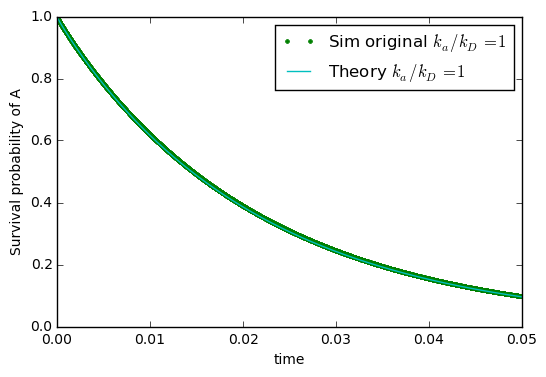

In [12]:
rm=voxelr
tau = ((ka*2*rm/(ka+kd))**2)/(D)
T=tc#np.arange(0,0.1,tm*10)
intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in T]

st = np.array([math.exp(-ik*N/Vr) for ik in intkt])
print T[st<0.1][0]
#plt.plot(tt[::40],(mna/N)[::40],'r.',label='Sim original $k_a/k_D=0.1$')
plt.plot(tc[::1],(mnac/N)[::1],'g.',label='Sim original $k_a/k_D=1$')
plt.plot(T,st,'c-',label='Theory $k_a/k_D=1$')
plt.legend(loc='best')
plt.ylabel('Survival probability of A')
plt.xlabel('time')
print mnac[-10:]
#plt.savefig("figure/survival_probability_ori_correct_theory.png",format='png',dpi=300)    

[ 384.43987918  383.8189074   383.19801564  382.58490528  381.97313516]
ka,kon,kefftheory
0.125663706144 0.0628318530718 0.0628362146758
0.00694170833376


(0.06361892005074532, 0.062909056429304888)

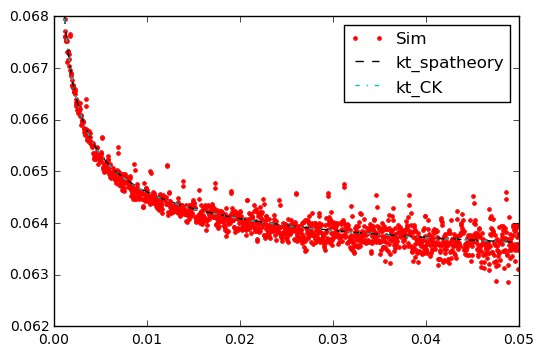

In [128]:
#corrected, trials=, alpha=0.1
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt
dat = np.loadtxt('kfacc1.0a01meanNar50k',delimiter=',')
#dat = np.loadtxt('/home/chew/wrk/spatiocyte/examples/accuracy/3D_reaction/ec3kfac1a01cor5000.csv',delimiter=',',skiprows=1)
lg=2
tc=dat[:,0][::lg]
mnac=dat[:,1][::lg]
print mnac[-5:]

k_factor = 1
f=1.021#1.020858
rm = 0.005  
voxelr=f*rm
L = 1.75#350*voxelr
D = 1
kd= 4.0*math.pi*D*2*rm
ka = k_factor*kd
kon = (ka*kd)/(ka+kd)
tm =(2*voxelr)**2/(6*D)
N = 4000
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,voxelr)

def getkt2(st,t): #two-point
    ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(t[2]-t[0])/N
    return ks

def getkt5(st,t): #five-point
    s1=st[0:-5]
    s2=st[1:-4]
    s4=st[3:-2]
    s5=st[4:-1]
    ks2= (-Vr*(-s5+8*s4-8*s2+s1)/s1/N/12./t[1]-t[0])
    return ks2

ks = getkt2(mnac,tc)
plt.plot(tc[1:-1],ks,'r.',label='Sim')

#plt.plot(tc[2:-3],ks2,'c-',label='five-point D')
r0=0.256318
Pacc= ka/3/2**0.5/D/2/voxelr
kdd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
kefftheory = kdd*Pacc/(Pacc+1/r0 -1)
#plt.plot(tc,[kon]*len(tc),label='keff')
#plt.plot(tc,[kefftheory]*len(tc),label='keff_theory')
print 'ka,kon,kefftheory'
print ka,kon,kefftheory
#lp = 200
#kstd=np.std(ks[-lp:])
#km = np.mean(ks[-lp:])
#print km,km-kstd,km+kstd
#print kstd
#print (km-kefftheory)*100/kefftheory
#print tc[-lp]

def Phi(xx):
    return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

def getktt(ka,kdd,rm,tc):
    tau = ((ka*2*rm/(ka+kdd))**2)/(D)
    kt1 = [(ka*kdd/(ka+kdd))*(1+(ka/kdd)*Phi(ka*(t/tau)**0.5 /kdd)) for t in tc]
    return kt1

kt1 = getktt(ka,kdd,rm,tc)
kt2 = getktt(ka,kd,rm,tc)
plt.plot(tc,kt1,'k--',label='kt_spatheory')
plt.plot(tc,kt2,'c-.',label='kt_CK')
#plt.plot(TT,KK,'g-')
#plt.xlim([0.09,0.1])
plt.ylim([0.062,0.068])
plt.legend()
print (kefftheory-kon)*100/kon
np.mean(ks[-100:]),np.mean(KK[-100:])

In [129]:
ll=-600
print tm*600
ksm = np.mean(ks[1:-1][ll:])
kt1m = np.mean(kt1[1:-1][ll:])
kt2m = np.mean(kt2[1:-1][ll:])
print (ksm-kt1m)*100/kt1m,(ksm-kt2m)*100/kt2m

0.01042441
-0.0316428495654 -0.0248012993264


0.0490642230667
[ 390.9808  390.0226  389.0785  388.1288  387.1873  386.2521  385.3205
  384.3836  383.4557  382.5504]


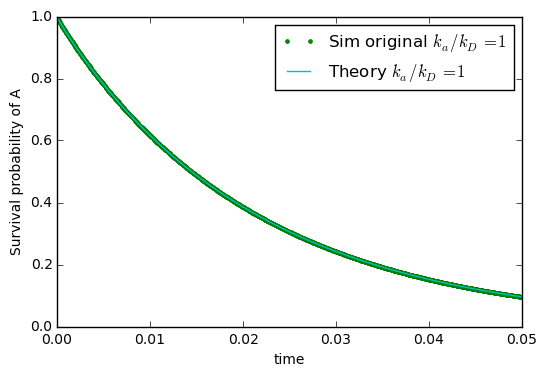

In [119]:
rm=voxelr
tau = ((ka*2*rm/(ka+kd))**2)/(D)
T=tc#np.arange(0,0.1,tm*10)
intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in T]

st = np.array([math.exp(-ik*N/Vr) for ik in intkt])
print T[st<0.1][0]
#plt.plot(tt[::40],(mna/N)[::40],'r.',label='Sim original $k_a/k_D=0.1$')
plt.plot(tc[::1],(mnac/N)[::1],'g.',label='Sim original $k_a/k_D=1$')
plt.plot(T,st,'c-',label='Theory $k_a/k_D=1$')
plt.legend(loc='best')
plt.ylabel('Survival probability of A')
plt.xlabel('time')
print mnac[-10:]
#plt.savefig("figure/survival_probability_ori_correct_theory.png",format='png',dpi=300)    